# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

Team Members:

Stylianos Sidiropoulos (stysi607)

Vasileia Kampouraki (vaska979)

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation.

In [1]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [2]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image, gaussFilter, mode="same")
filterResponseSobelX = signal.convolve2d(image, sobelX, mode="same")
filterResponseSobelY = signal.convolve2d(image, sobelY, mode="same")

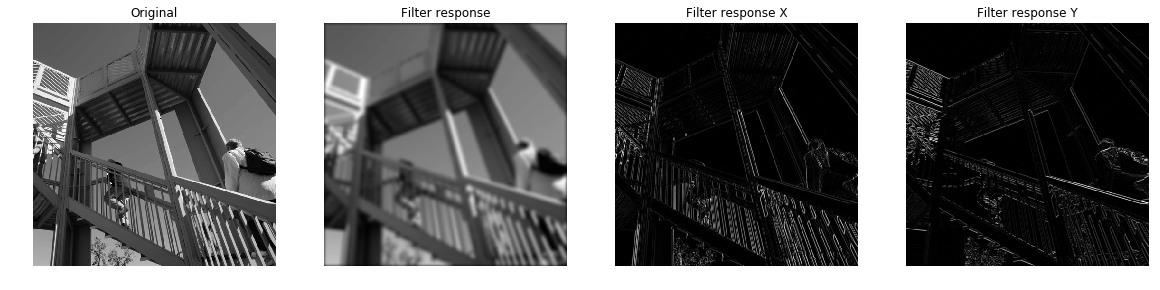

In [4]:
# Show filter responses
import matplotlib.pyplot as plt
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response X')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response Y')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

Answer 1: Gaussian filter blurs the image, SobelX filter emphasising edges in the x-axis whereas SobelY filter in the y-axis.

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

Answer 2: Running `image.shape` in Python we see that the original image is (512, 512). Running `len(image.shape)` we get 2, so it has a single channel. A color image normally has 3 channels each for the colors red, green and blue.

Question 3: What is the size of the different filters?

Answer 3: Both Sobel filters have a size 3x3. Gaussian filter has a size of 15x15.

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

Answer 4: The size of the filter responses is the same as the original image.

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

Answer 5: The size of the Gaussian filter response is 498x498 and the size of the SobelX and SobelY filters is 510x510. 

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?

Answer 6: 


In [5]:
# Your code for checking sizes of image and filter responses
print("Original Image size:", image.shape)
print("Image size with Gaussian filter:", filterResponseGauss.shape)
print("Image size with SobelX filter:", filterResponseSobelX.shape)
print("Image size with SobelY filter:", filterResponseSobelY.shape)
print("")
print("Gayssian filter size:", gaussFilter.shape)
print("SobelX filter:", sobelX.shape)
print("SobelY filter:", sobelY.shape)

Original Image size: (512, 512)
Image size with Gaussian filter: (512, 512)
Image size with SobelX filter: (512, 512)
Image size with SobelY filter: (512, 512)

Gayssian filter size: (15, 15)
SobelX filter: (3, 3)
SobelY filter: (3, 3)


##  Part 3: Get a graphics card

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [6]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

Using TensorFlow backend.


##  Part 4: How fast is the graphics card?

Lets investigate how much faster a convolution is with the graphics card

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ? 

Answer 7: The extra last dimension is for the number of channels the filter will have (red, green, blue so 3 channels)

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

Answer 8: According to the documentation (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), the Conv2D layer creates a convolution kernel that is convolved with the input layer to produce an output.

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?

Answer 9: GPU is about 5 times faster than the CPU.

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.

Answer 10: In this case the GPU is only x1 faster than the CPU. The difference with the 100 images result is notable. The larger the batch size, the larger the difference in the performance between GPU and CPU. 

In [11]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 100

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.0172351539999909
GPU (s):
0.19672758100000465
GPU speedup over CPU: 5x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [12]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 


In [13]:
# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

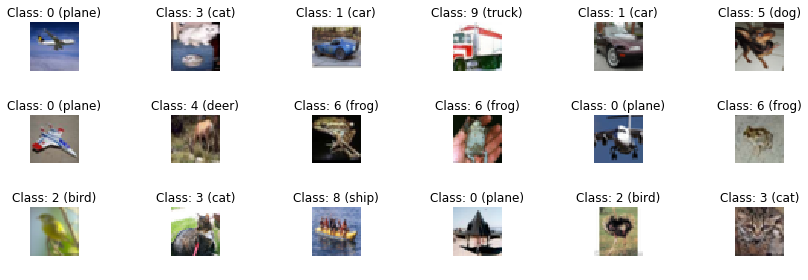

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [15]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25)

# Print the size of training data, validation data and test data
print('Xtrain {}, Ytrain {}'.format(Xtrain.shape, Ytrain.shape))
print('Xtest {}, Ytest {}'.format(Xtest.shape, Ytest.shape))
print('Xval {}, Yval {}'.format(Xval.shape, Yval.shape))

Xtrain (7500, 32, 32, 3), Ytrain (7500, 1)
Xtest (2000, 32, 32, 3), Ytest (2000, 1)
Xval (2500, 32, 32, 3), Yval (2500, 1)


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [16]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/utils/#to_categorical

In [17]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print('Ytrain {}'.format(Ytrain.shape))
print('Ytest {}'.format(Ytest.shape))
print('Yval {}'.format(Yval.shape))

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain = to_categorical(Ytrain)
Ytest = to_categorical(Ytest)
Yval = to_categorical(Yval)

# Print shapes after converting the labels
print('Ytrain {}'.format(Ytrain.shape))
print('Ytest {}'.format(Ytest.shape))
print('Yval {}'.format(Yval.shape))

Ytrain (7500, 1)
Ytest (2000, 1)
Yval (2500, 1)
Ytrain (7500, 10)
Ytest (2000, 10)
Yval (2500, 10)


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [18]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy as CC

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):

    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
        n_filters = 2*n_filters
        model.add(Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Add flatten layer
    model.add(Flatten())
                  
    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(n_nodes, activation='relu'))
        model.add(BatchNormalization())
        if use_dropout == True:
            model.add(Dropout(rate=0.5))
    
    # Add final dense layer
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile(loss=CC, optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
                  
    return model

In [19]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

## 2 convolutional layers, no intermediate dense layers

In [20]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32, 32, 3)

# Build model
model1 = build_CNN(input_shape=input_shape) 

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 10s - loss: 2.8868 - accuracy: 0.3240 - val_loss: 2.1816 - val_accuracy: 0.3088
Epoch 2/20
 - 1s - loss: 1.6479 - accuracy: 0.4641 - val_loss: 1.7264 - val_accuracy: 0.3872
Epoch 3/20
 - 1s - loss: 1.2598 - accuracy: 0.5585 - val_loss: 1.6629 - val_accuracy: 0.3816
Epoch 4/20
 - 1s - loss: 1.0974 - accuracy: 0.6116 - val_loss: 1.4398 - val_accuracy: 0.4676
Epoch 5/20
 - 1s - loss: 0.9823 - accuracy: 0.6595 - val_loss: 1.3497 - val_accuracy: 0.5276
Epoch 6/20
 - 1s - loss: 0.9228 - accuracy: 0.6765 - val_loss: 1.3694 - val_accuracy: 0.5392
Epoch 7/20
 - 1s - loss: 0.8078 - accuracy: 0.7191 - val_loss: 1.4152 - val_accuracy: 0.5512
Epoch 8/20
 - 1s - loss: 0.7310 - accuracy: 0.7481 - val_loss: 1.5014 - val_accuracy: 0.5556
Epoch 9/20
 - 1s - loss: 0.6801 - accuracy: 0.7647 - val_loss: 1.6139 - val_accuracy: 0.5512
Epoch 10/20
 - 1s - loss: 0.6241 - accuracy: 0.7795 - val_loss: 1.6764 - val_accuracy: 0.5604
Epoch 11/20
 - 1s - 

In [21]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest, batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 65us/step
Test loss: 2.7989
Test accuracy: 0.5460


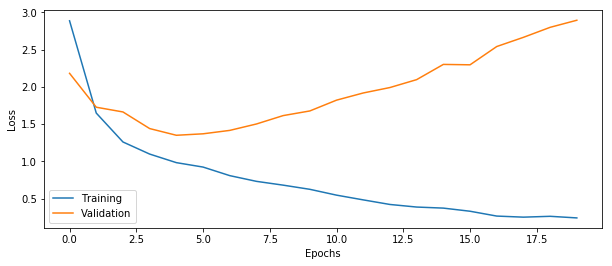

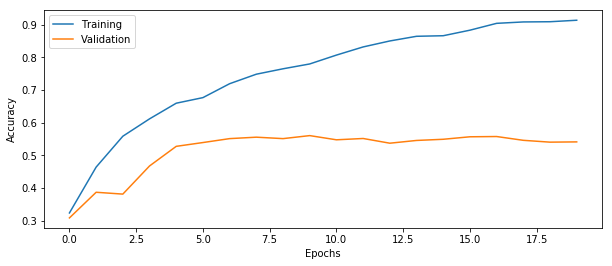

In [22]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance
Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 

Question 11: How big is the difference between training and test accuracy?

Answer: 11: The difference between training and test accuracy is almost 40%.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training. 

Answer 12: 70%. GPU memory used 11023MiB

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

Answer 13: Due to the fact that we have to deal with images in this laboration and since images demand more complex calculations, we need to lower the batch size value.

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [23]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32, 32, 3)

# Build model
model2 = build_CNN(input_shape=input_shape, n_dense_layers=1) 

# Train the model  using training data and validation data
history2 = model2.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 2s - loss: 1.6429 - accuracy: 0.4111 - val_loss: 2.0457 - val_accuracy: 0.2452
Epoch 2/20
 - 1s - loss: 1.2386 - accuracy: 0.5572 - val_loss: 1.9157 - val_accuracy: 0.3180
Epoch 3/20
 - 1s - loss: 1.0397 - accuracy: 0.6301 - val_loss: 1.5960 - val_accuracy: 0.4316
Epoch 4/20
 - 1s - loss: 0.8664 - accuracy: 0.6939 - val_loss: 1.2796 - val_accuracy: 0.5432
Epoch 5/20
 - 1s - loss: 0.7008 - accuracy: 0.7555 - val_loss: 1.4700 - val_accuracy: 0.5388
Epoch 6/20
 - 1s - loss: 0.5654 - accuracy: 0.8023 - val_loss: 1.5234 - val_accuracy: 0.5684
Epoch 7/20
 - 1s - loss: 0.3999 - accuracy: 0.8644 - val_loss: 1.6547 - val_accuracy: 0.5632
Epoch 8/20
 - 1s - loss: 0.3028 - accuracy: 0.8947 - val_loss: 2.0426 - val_accuracy: 0.5604
Epoch 9/20
 - 1s - loss: 0.2233 - accuracy: 0.9248 - val_loss: 2.1198 - val_accuracy: 0.5504
Epoch 10/20
 - 1s - loss: 0.1811 - accuracy: 0.9405 - val_loss: 2.2416 - val_accuracy: 0.5636
Epoch 11/20
 - 1s - l

In [24]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest, Ytest, batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 67us/step
Test loss: 3.3875
Test accuracy: 0.5275


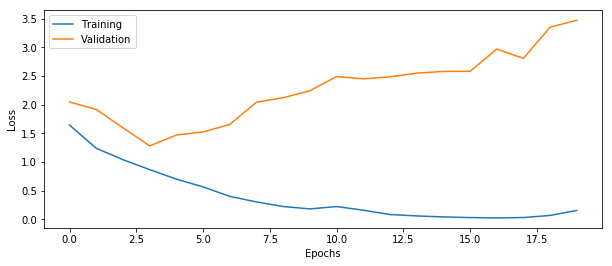

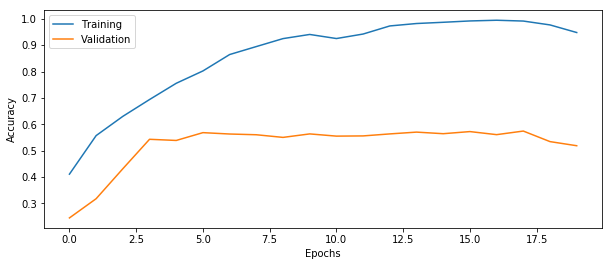

In [25]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [26]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32, 32, 3)

# Build model
model3 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_dense_layers=1)

# Train the model  using training data and validation data
history3 = model3.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 3s - loss: 1.7169 - accuracy: 0.3859 - val_loss: 2.2467 - val_accuracy: 0.2732
Epoch 2/20
 - 2s - loss: 1.3496 - accuracy: 0.5073 - val_loss: 1.9380 - val_accuracy: 0.3428
Epoch 3/20
 - 2s - loss: 1.1720 - accuracy: 0.5820 - val_loss: 1.5794 - val_accuracy: 0.4496
Epoch 4/20
 - 2s - loss: 1.0177 - accuracy: 0.6345 - val_loss: 1.4766 - val_accuracy: 0.4964
Epoch 5/20
 - 2s - loss: 0.8817 - accuracy: 0.6853 - val_loss: 1.7385 - val_accuracy: 0.5060
Epoch 6/20
 - 2s - loss: 0.7168 - accuracy: 0.7492 - val_loss: 1.8009 - val_accuracy: 0.5384
Epoch 7/20
 - 2s - loss: 0.5928 - accuracy: 0.7927 - val_loss: 1.8677 - val_accuracy: 0.5388
Epoch 8/20
 - 2s - loss: 0.4831 - accuracy: 0.8295 - val_loss: 1.7299 - val_accuracy: 0.5588
Epoch 9/20
 - 2s - loss: 0.3778 - accuracy: 0.8664 - val_loss: 1.9385 - val_accuracy: 0.5776
Epoch 10/20
 - 2s - loss: 0.2983 - accuracy: 0.8940 - val_loss: 1.9766 - val_accuracy: 0.5896
Epoch 11/20
 - 2s - l

In [27]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest, Ytest, batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 67us/step
Test loss: 2.5397
Test accuracy: 0.5930


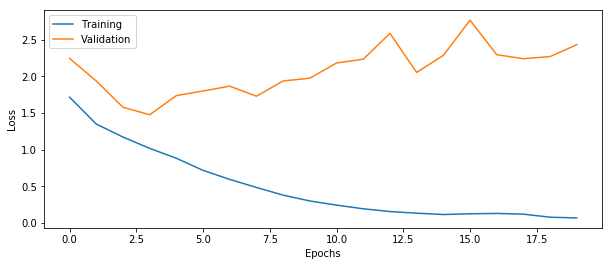

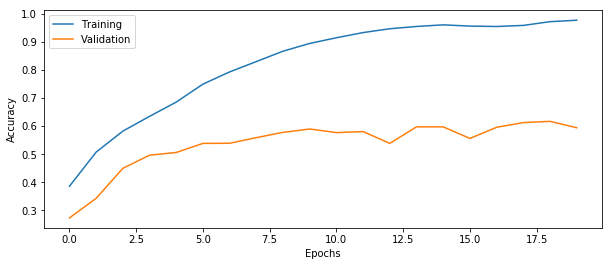

In [28]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

Answer 14: The network has 124,180 trainable paramenters. They are also the majority of the total parameters, as non-trainable parameters are only 580.

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 

Answer 15: A Conv2D layer gets as input a 4D tensor with shape `(batch, channels, rows, columns)` and has as output a 4D tensor with shape `(batch, filters, new_rows, new_columns)`. The dimensions of input and output are 4, as expected.

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

Answer 16: Yes. In any case, the batch size is always the first dimension of each 4D tensor.

Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

Answer 17: 

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

Answer 18: 

Question 19: How does MaxPooling help in reducing the number of parameters to train?

Answer 19: 

In [29]:
# Print network architecture
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)         

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?

Answer 20: Test accuracy without dropout (model3) is 0.5930, whereas with dropout is 0.6100 so there is a small improvement of 0.017.

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?

Answer 21: 


## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [30]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32, 32, 3)

# Build model
model4 = build_CNN(input_shape=input_shape, n_conv_layers=4, n_dense_layers=1, use_dropout=True)

# Train the model  using training data and validation data
history4 = model4.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
 - 3s - loss: 1.9798 - accuracy: 0.3029 - val_loss: 1.9396 - val_accuracy: 0.3444
Epoch 2/20
 - 2s - loss: 1.5812 - accuracy: 0.4119 - val_loss: 2.3208 - val_accuracy: 0.2500
Epoch 3/20
 - 2s - loss: 1.4112 - accuracy: 0.4787 - val_loss: 1.6929 - val_accuracy: 0.4020
Epoch 4/20
 - 2s - loss: 1.2950 - accuracy: 0.5340 - val_loss: 1.3655 - val_accuracy: 0.4948
Epoch 5/20
 - 2s - loss: 1.1749 - accuracy: 0.5801 - val_loss: 1.5413 - val_accuracy: 0.5208
Epoch 6/20
 - 2s - loss: 1.0699 - accuracy: 0.6192 - val_loss: 1.3651 - val_accuracy: 0.5476
Epoch 7/20
 - 2s - loss: 0.9511 - accuracy: 0.6669 - val_loss: 1.2394 - val_accuracy: 0.5872
Epoch 8/20
 - 2s - loss: 0.8751 - accuracy: 0.6912 - val_loss: 1.7176 - val_accuracy: 0.5212
Epoch 9/20
 - 2s - loss: 0.7780 - accuracy: 0.7292 - val_loss: 1.5900 - val_accuracy: 0.5940
Epoch 10/20
 - 2s - loss: 0.6584 - accuracy: 0.7780 - val_loss: 1.5427 - val_accuracy: 0.5752
Epoch 11/20
 - 2s - l

In [31]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest, Ytest, batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 81us/step
Test loss: 2.0470
Test accuracy: 0.6100


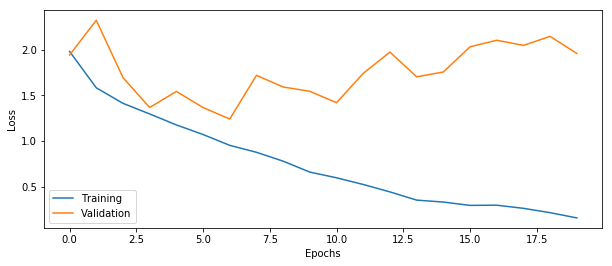

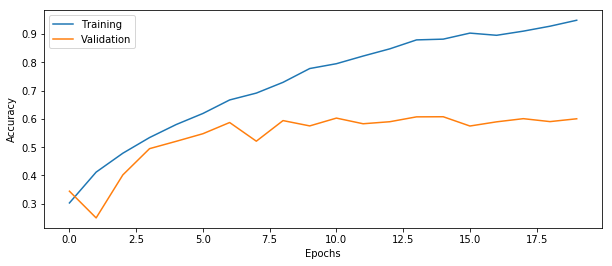

In [32]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration?

Answer 22: We've achieved 64.35% test accuracy with the following settings: `batch_size=500`, `epochs=100`, `n_conv_layers=4`, `n_filters=64`, `n_dense_layers=1`, `n_nodes=500`, `learning_rate=0.01` and dropout.

## Your best config

In [33]:
# Setup some training parameters
batch_size = 500
epochs = 100
input_shape = (32, 32, 3)

# Build model
model5 = build_CNN(input_shape, n_conv_layers=4, n_filters=64, n_dense_layers=1, n_nodes=500, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history5 = model5.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(Xval, Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/100
 - 7s - loss: 2.9744 - accuracy: 0.2279 - val_loss: 109.6024 - val_accuracy: 0.1000
Epoch 2/100
 - 3s - loss: 1.9331 - accuracy: 0.3285 - val_loss: 13.9513 - val_accuracy: 0.1940
Epoch 3/100
 - 4s - loss: 1.7122 - accuracy: 0.3824 - val_loss: 5.7251 - val_accuracy: 0.1732
Epoch 4/100
 - 4s - loss: 1.5715 - accuracy: 0.4259 - val_loss: 4.6214 - val_accuracy: 0.1344
Epoch 5/100
 - 3s - loss: 1.4567 - accuracy: 0.4609 - val_loss: 4.7058 - val_accuracy: 0.1580
Epoch 6/100
 - 4s - loss: 1.3540 - accuracy: 0.4965 - val_loss: 6.4769 - val_accuracy: 0.1136
Epoch 7/100
 - 4s - loss: 1.2697 - accuracy: 0.5381 - val_loss: 5.4050 - val_accuracy: 0.1420
Epoch 8/100
 - 4s - loss: 1.1682 - accuracy: 0.5741 - val_loss: 4.8500 - val_accuracy: 0.1508
Epoch 9/100
 - 4s - loss: 1.0353 - accuracy: 0.6224 - val_loss: 4.2013 - val_accuracy: 0.1448
Epoch 10/100
 - 4s - loss: 0.9092 - accuracy: 0.6659 - val_loss: 5.5123 - val_accuracy: 0.1524
Epoch 11

 - 4s - loss: 8.7697e-05 - accuracy: 1.0000 - val_loss: 2.7030 - val_accuracy: 0.6408
Epoch 87/100
 - 4s - loss: 9.3199e-05 - accuracy: 1.0000 - val_loss: 2.6997 - val_accuracy: 0.6416
Epoch 88/100
 - 4s - loss: 7.2829e-05 - accuracy: 1.0000 - val_loss: 2.6978 - val_accuracy: 0.6420
Epoch 89/100
 - 4s - loss: 1.1078e-04 - accuracy: 1.0000 - val_loss: 2.6968 - val_accuracy: 0.6432
Epoch 90/100
 - 4s - loss: 9.4566e-05 - accuracy: 1.0000 - val_loss: 2.6948 - val_accuracy: 0.6452
Epoch 91/100
 - 4s - loss: 5.6686e-05 - accuracy: 1.0000 - val_loss: 2.6915 - val_accuracy: 0.6460
Epoch 92/100
 - 4s - loss: 6.2331e-05 - accuracy: 1.0000 - val_loss: 2.6914 - val_accuracy: 0.6448
Epoch 93/100
 - 4s - loss: 5.2596e-05 - accuracy: 1.0000 - val_loss: 2.6926 - val_accuracy: 0.6460
Epoch 94/100
 - 4s - loss: 5.7726e-05 - accuracy: 1.0000 - val_loss: 2.7056 - val_accuracy: 0.6476
Epoch 95/100
 - 4s - loss: 5.8328e-05 - accuracy: 1.0000 - val_loss: 2.7224 - val_accuracy: 0.6464
Epoch 96/100
 - 4s - lo

In [34]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest, Ytest, batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 151us/step
Test loss: 2.6797
Test accuracy: 0.6595


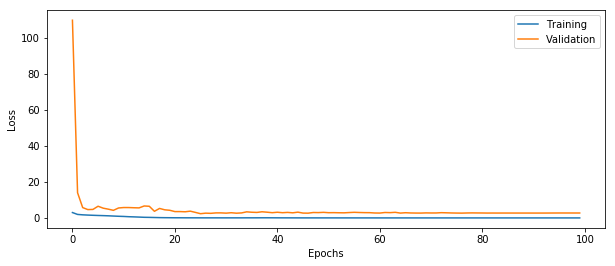

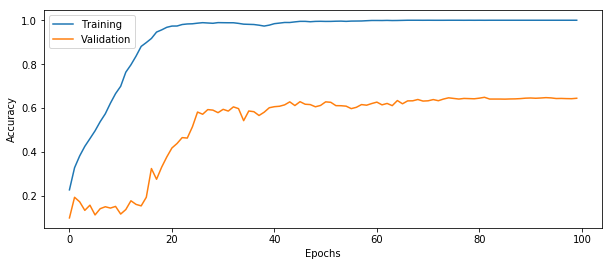

In [35]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

Answer 23: Test accuracy for rotated test images is 0.2270, whereas it is 0.6435 without rotation. Test accuracy when rotating the images fall dramatically, because the model hadn't been trained with images and the rotations of them, so it can't classify each rotated image correctly.

In [36]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

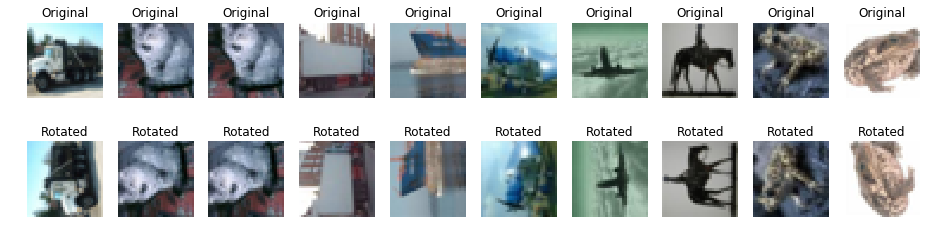

In [37]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [38]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(Xtest_rotated, Ytest, batch_size=batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 139us/step
Test loss: 8.9624
Test accuracy: 0.2205


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/

In [39]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [40]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=30, horizontal_flip=True, vertical_flip=True, validation_split=0.2)

# Setup a flow for training data, assume that we can fit all images into CPU memory
flow_train = datagen.flow(Xtrain, Ytrain, batch_size=100, subset="training")

# Setup a flow for validation data, assume that we can fit all images into CPU memory
flow_val = datagen.flow(Xval, Yval, batch_size=100, subset="validation")


## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

Answer 24: We tweak the batch_size value, so we can fit all training images in CPU memory. The main disandvantage of doing so is that...

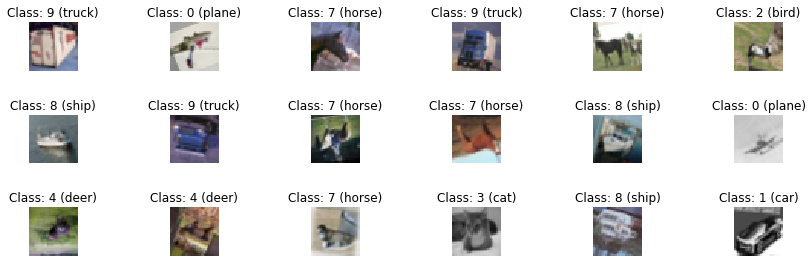

In [41]:
# Plot some augmented images
#plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)
plot_datagen = flow_train

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/models/model/ for how to use model.fit_generator instead of model.fit for training

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

Answer 25: If we want to perform more training, we need to increase the batch_size parameter.

Question 26: What other types of image augmentation can be applied, compared to what we use here?

Answer 26: 

In [42]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = (32, 32, 3)

# Build model (your best config)
model6 = model5

validation_split=0.2
    
# Train the model using on the fly augmentation
history6 = model6.fit_generator(flow_train, steps_per_epoch=len(Xtrain)*(1-validation_split)/batch_size, 
                                validation_data=flow_val, validation_steps=len(Xtrain)*validation_split/batch_size,
                                epochs=epochs)

Epoch 1/200
80/80 [==============================] - 6s 78ms/step - loss: 2.6504 - accuracy: 0.2473 - val_loss: 5.2252 - val_accuracy: 0.1695
Epoch 2/200
80/80 [==============================] - 6s 71ms/step - loss: 1.8167 - accuracy: 0.3205 - val_loss: 1.8991 - val_accuracy: 0.3005
Epoch 3/200
80/80 [==============================] - 6s 71ms/step - loss: 1.6959 - accuracy: 0.3689 - val_loss: 1.6906 - val_accuracy: 0.3840
Epoch 4/200
80/80 [==============================] - 6s 72ms/step - loss: 1.6279 - accuracy: 0.3991 - val_loss: 1.7298 - val_accuracy: 0.3930
Epoch 5/200
80/80 [==============================] - 6s 71ms/step - loss: 1.5569 - accuracy: 0.4207 - val_loss: 1.4038 - val_accuracy: 0.4390
Epoch 6/200
80/80 [==============================] - 6s 71ms/step - loss: 1.5177 - accuracy: 0.4400 - val_loss: 1.6228 - val_accuracy: 0.4400
Epoch 7/200
80/80 [==============================] - 6s 71ms/step - loss: 1.4652 - accuracy: 0.4600 - val_loss: 1.4721 - val_accuracy: 0.4695
Epoch 

80/80 [==============================] - 6s 72ms/step - loss: 0.2323 - accuracy: 0.9230 - val_loss: 0.3923 - val_accuracy: 0.8950
Epoch 116/200
80/80 [==============================] - 6s 71ms/step - loss: 0.2351 - accuracy: 0.9195 - val_loss: 0.4627 - val_accuracy: 0.8780
Epoch 117/200
80/80 [==============================] - 6s 71ms/step - loss: 0.2139 - accuracy: 0.9259 - val_loss: 0.2944 - val_accuracy: 0.8945
Epoch 118/200
80/80 [==============================] - 6s 71ms/step - loss: 0.2213 - accuracy: 0.9259 - val_loss: 0.2624 - val_accuracy: 0.8940
Epoch 119/200
80/80 [==============================] - 6s 71ms/step - loss: 0.2089 - accuracy: 0.9312 - val_loss: 0.4794 - val_accuracy: 0.8695
Epoch 120/200
80/80 [==============================] - 6s 71ms/step - loss: 0.2150 - accuracy: 0.9277 - val_loss: 0.6468 - val_accuracy: 0.8865
Epoch 121/200
80/80 [==============================] - 6s 71ms/step - loss: 0.2157 - accuracy: 0.9280 - val_loss: 0.4633 - val_accuracy: 0.8980
Epoch 

Epoch 172/200
80/80 [==============================] - 6s 71ms/step - loss: 0.1361 - accuracy: 0.9553 - val_loss: 0.2704 - val_accuracy: 0.9065
Epoch 173/200
80/80 [==============================] - 6s 71ms/step - loss: 0.1495 - accuracy: 0.9525 - val_loss: 0.5784 - val_accuracy: 0.9070
Epoch 174/200
80/80 [==============================] - 6s 71ms/step - loss: 0.1640 - accuracy: 0.9470 - val_loss: 0.5422 - val_accuracy: 0.8885
Epoch 175/200
80/80 [==============================] - 6s 72ms/step - loss: 0.1688 - accuracy: 0.9476 - val_loss: 0.4855 - val_accuracy: 0.8980
Epoch 176/200
80/80 [==============================] - 6s 71ms/step - loss: 0.1667 - accuracy: 0.9454 - val_loss: 0.3912 - val_accuracy: 0.8875
Epoch 177/200
80/80 [==============================] - 6s 70ms/step - loss: 0.1469 - accuracy: 0.9486 - val_loss: 0.5179 - val_accuracy: 0.9095
Epoch 178/200
80/80 [==============================] - 6s 72ms/step - loss: 0.1604 - accuracy: 0.9467 - val_loss: 0.2027 - val_accuracy:

In [43]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.8474
Test accuracy: 0.6660
Test loss: 5.1809
Test accuracy: 0.3305


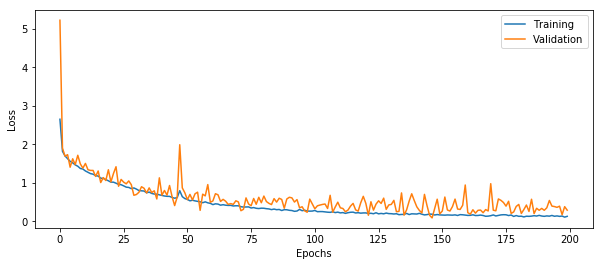

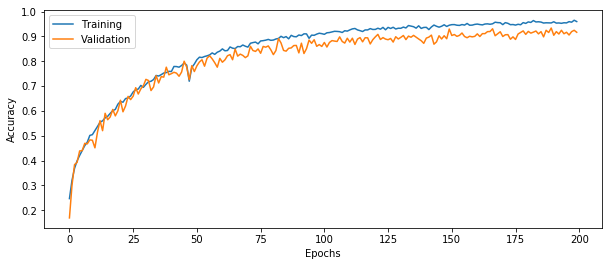

In [44]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly

In [45]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest,axis=1)

miss = np.flatnonzero(y_correct != y_pred)

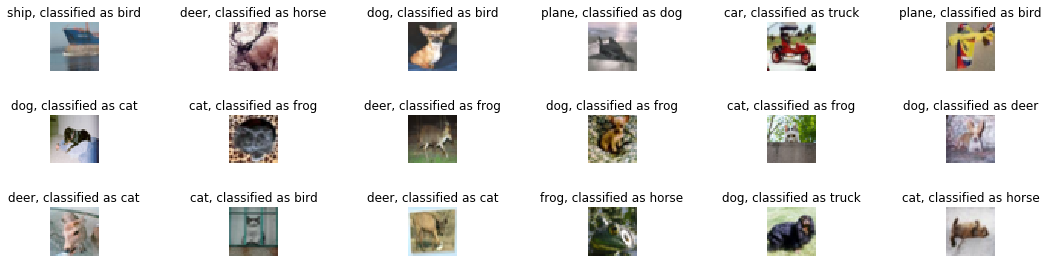

In [46]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

Answer 27: 

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

Answer 28: 

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database. Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 

Answer 29: 

Question 30: How many trainable parameters does the ResNet50 network have? 

Answer 30: 

Question 31: What is the size of the images that ResNet50 expects as input?

Answer 31: 

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

Answer 32: 

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine. Are the predictions correct? How certain is the network of each image class?

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/applications/#resnet

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


In [1]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice

